In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

from low_fidelity.main import HyperParams as LowFidelityHyperParams, simulate as low_fidelity_simulate
from high_fidelity.py_interface import HyperParams as HighFidelityHyperParams, simulate as high_fidelity_simulate

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
import json

import GPy
from emukit.core import ContinuousParameter, DiscreteParameter, ParameterSpace

with open("model/lf_params_acq_opt.json") as f:
    lf_params = json.load(f)
    lf_model = GPy.models.GPRegression.from_dict(lf_params)

In [5]:
import sys
from typing import Optional
from multiprocessing import Pool

import GPy
import numpy as np
from emukit.bayesian_optimization.acquisitions.entropy_search import (
    MultiInformationSourceEntropySearch,
)
from emukit.core import (
    ContinuousParameter,
    DiscreteParameter,
    InformationSourceParameter,
    ParameterSpace,
)
from emukit.core.acquisition import Acquisition
from emukit.core.initial_designs.latin_design import LatinDesign
from emukit.core.loop import FixedIntervalUpdater, OuterLoop, SequentialPointCalculator
from emukit.core.loop.loop_state import create_loop_state
from emukit.core.loop.user_function import MultiSourceFunctionWrapper
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.core.optimization.multi_source_acquisition_optimizer import (
    MultiSourceAcquisitionOptimizer,
)
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.convert_lists_to_array import (
    convert_x_list_to_array,
    convert_xy_lists_to_arrays,
)
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel

from emulation.emukit_custom import LinearMultiFidelityModel, LinearMultiFidelityKernel
from high_fidelity.py_interface import HyperParams as HighFidelityHyperParams
from high_fidelity.py_interface import simulate as high_fidelity_simulate
from low_fidelity.main import HyperParams as LowFidelityHyperParams
from low_fidelity.main import simulate as low_fidelity_simulate

n_fidelities = 2

space = ParameterSpace(
    [
        DiscreteParameter("INIT_PRED", range(0, 501)),
        DiscreteParameter("INIT_PREY", range(0, 501)),
        ContinuousParameter("PRED_SPAWN_RATE", 0, 2),
        ContinuousParameter("PREY_SPAWN_RATE", 0, 2),
        ContinuousParameter("PREY_DEATH_FROM_PRED", 0, 1),
        InformationSourceParameter(n_fidelities),
    ]
)


class CustomDesign(LatinDesign):
    def get_samples(self, point_count: int) -> np.ndarray:
        samples = super().get_samples(point_count)
        prey_spawn_rate_idx = space.find_parameter_index_in_model("PREY_SPAWN_RATE")[0]
        for i in range(len(samples)):
            samples[i, prey_spawn_rate_idx] = np.random.choice(
                [0, np.random.uniform(0, 0.1), np.random.uniform(0.1, 2)]
            )
        return samples


def f_low(X: np.ndarray):
    """Low fidelity function to emulate"""

    hps = []
    for x_vec in X:
        hp = LowFidelityHyperParams(
            STEPS=500,
            INIT_PREY=int(x_vec[0]),
            INIT_PRED=int(x_vec[1]),
            PRED_SPAWN_RATE=x_vec[2],
            PREY_SPAWN_RATE=x_vec[3],
            PREY_DEATH_FROM_PRED=x_vec[4],
        )
        hps.append(hp)

    with Pool(4) as p:
        runs = p.map(low_fidelity_simulate, hps)

    avg_preds = []
    for summaries in runs:
        n_preds = [summary.num_preds for summary in summaries]
        avg_preds.append(np.mean(n_preds[len(n_preds) // 2 :]))

    return np.array(avg_preds).reshape(-1, 1)


def f_high(X: np.ndarray):
    """High fidelity function to emulate"""

    avg_preds = []
    for x_vec in X:
        hp = HighFidelityHyperParams(
            STEPS=1000,
            STARTING_PREY=int(x_vec[0]),
            STARTING_PREDATOR=int(x_vec[1]),
            PREDATOR_SPAWN_RATE=x_vec[2],
            PREY_SPAWN_RATE=x_vec[3],
            PREDATOR_EATING_PROBABILITY=x_vec[4],
        )

        n_preds = []
        print(f"Running high fidelity with {hp}")
        for summary in high_fidelity_simulate(hp, path_to_out="high_fidelity/out"):
            n_preds.append(summary.num_preds)
        avg_preds.append(np.mean(n_preds[len(n_preds) // 2 :]))

    return np.array(avg_preds).reshape(-1, 1)


f = MultiSourceFunctionWrapper([f_low, f_high])

design = CustomDesign(ParameterSpace(space.parameters[:-1]))

X_train_low = lf_model.X
Y_train_low = lf_model.Y

n_starts_high = 20
X_train_high = design.get_samples(n_starts_high)
Y_train_high = f_high(X_train_high)

X_train, Y_train = convert_xy_lists_to_arrays([X_train_low, X_train_high], [Y_train_low, Y_train_high])

Running high fidelity with HyperParams(REPRODUCTION_TYPE='FOOD', STEPS=1000, STARTING_PREY=12, STARTING_PREDATOR=337, STARTING_BERRY=0, MAX_BERRY=500, BERRY_VALUE=50, PREY_VALUE=50, PREY_STARTING_ENERGY=50, PREDATOR_STARTING_ENERGY=50, PREY_STARVATION=2, PREDATOR_STARVATION=2, PREY_STEP_ENERGY=0, PREDATOR_STEP_ENERGY=0, EATING_RADIUS=28.209479177387816, PREDATOR_EATING_PROBABILITY=0.32500000000000007, PREY_REPRODUCTION_ENERGY_THRESHOLD=100, PREDATOR_REPRODUCTION_ENERGY_THRESHOLD=100, PREY_REPRODUCTION_PROBABILITY=1, PREDATOR_REPRODUCTION_PROBABILITY=1, SPEED=80, PREY_SPAWN_RATE=0.07816235953639676, PREDATOR_SPAWN_RATE=0.55, BERRY_SPAWN_RATE=10, SIMULATION_TIMESTEP=0.5)
Running high fidelity with HyperParams(REPRODUCTION_TYPE='FOOD', STEPS=1000, STARTING_PREY=312, STARTING_PREDATOR=213, STARTING_BERRY=0, MAX_BERRY=500, BERRY_VALUE=50, PREY_VALUE=50, PREY_STARTING_ENERGY=50, PREDATOR_STARTING_ENERGY=50, PREY_STARVATION=2, PREDATOR_STARVATION=2, PREY_STEP_ENERGY=0, PREDATOR_STEP_ENERGY=0,

In [37]:
from emukit.model_wrappers import GPyMultiOutputWrapper
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance
from emukit.bayesian_optimization.acquisitions.entropy_search import MultiInformationSourceEntropySearch
from emukit.core.acquisition import Acquisition

length_scales = {
    "INIT_PRED": 1000,
    "INIT_PREY": 1000,
    "PRED_SPAWN_RATE": 2,
    "PREY_SPAWN_RATE": 10,
    "PREY_DEATH_FROM_PRED": 0.4,
}

# low_kernel = GPy.kern.Matern32(
#     space.dimensionality - 1,
#     lengthscale=[length_scales[x_var] for x_var in space.parameter_names[:-1]],
#     ARD=True,
# )
err_kernel = GPy.kern.Matern32(
    space.dimensionality - 1,
    variance=2,
    lengthscale=[length_scales[x_var] for x_var in space.parameter_names[:-1]],
    ARD=True,
)
mf_kernel = LinearMultiFidelityKernel([lf_model.kern, err_kernel])

mf_model = LinearMultiFidelityModel(
    X_train,
    Y_train,
    mf_kernel,
    mf_kernel.n_fidelities,
    GPy.likelihoods.mixed_noise.MixedNoise(
        [
            # lf_model.likelihood,
            GPy.likelihoods.Gaussian(variance=0.05**2),
            GPy.likelihoods.Gaussian(variance=0.1**2),
        ]
    ),
    normalizer=True,
)
mf_model.optimize()

In [41]:
# Define cost of different fidelities as acquisition function
class Cost(Acquisition):
    def __init__(self, costs):
        self.costs = costs

    def evaluate(self, x):
        fidelity_index = x[:, -1].astype(int)
        x_cost = np.array([self.costs[i] for i in fidelity_index])
        return x_cost[:, None]

    @property
    def has_gradients(self):
        return True

    def evaluate_with_gradients(self, x):
        return self.evaluate(x), np.zeros(x.shape)


emukit_model = GPyMultiOutputWrapper(mf_model, n_outputs=2, n_optimization_restarts=1)

# low_fidelity_cost = 1
# high_fidelity_cost = 2
n_acq = 100

# cost_acquisition = Cost([low_fidelity_cost, high_fidelity_cost])
# acquisition = ModelVariance(emukit_model) / cost_acquisition
X_acq = CustomDesign(space).get_samples(n_acq)
acquisition = IntegratedVarianceReduction(emukit_model, space, x_monte_carlo=X_acq)
acquisition_optimizer = MultiSourceAcquisitionOptimizer(GradientAcquisitionOptimizer(space), space)
loop = ExperimentalDesignLoop(space, emukit_model, acquisition)

loop.run_loop(lambda X: np.array([r.Y for r in f(X)]), 3, context={"source": 1})

Running high fidelity with HyperParams(REPRODUCTION_TYPE='FOOD', STEPS=1000, STARTING_PREY=12, STARTING_PREDATOR=316, STARTING_BERRY=0, MAX_BERRY=500, BERRY_VALUE=50, PREY_VALUE=50, PREY_STARTING_ENERGY=50, PREDATOR_STARTING_ENERGY=50, PREY_STARVATION=2, PREDATOR_STARVATION=2, PREY_STEP_ENERGY=0, PREDATOR_STEP_ENERGY=0, EATING_RADIUS=28.209479177387816, PREDATOR_EATING_PROBABILITY=0.7289367111291367, PREY_REPRODUCTION_ENERGY_THRESHOLD=100, PREDATOR_REPRODUCTION_ENERGY_THRESHOLD=100, PREY_REPRODUCTION_PROBABILITY=1, PREDATOR_REPRODUCTION_PROBABILITY=1, SPEED=80, PREY_SPAWN_RATE=0.588554964469808, PREDATOR_SPAWN_RATE=0.8456217376215276, BERRY_SPAWN_RATE=10, SIMULATION_TIMESTEP=0.5)
Running high fidelity with HyperParams(REPRODUCTION_TYPE='FOOD', STEPS=1000, STARTING_PREY=340, STARTING_PREDATOR=49, STARTING_BERRY=0, MAX_BERRY=500, BERRY_VALUE=50, PREY_VALUE=50, PREY_STARTING_ENERGY=50, PREDATOR_STARTING_ENERGY=50, PREY_STARVATION=2, PREDATOR_STARVATION=2, PREY_STEP_ENERGY=0, PREDATOR_STEP

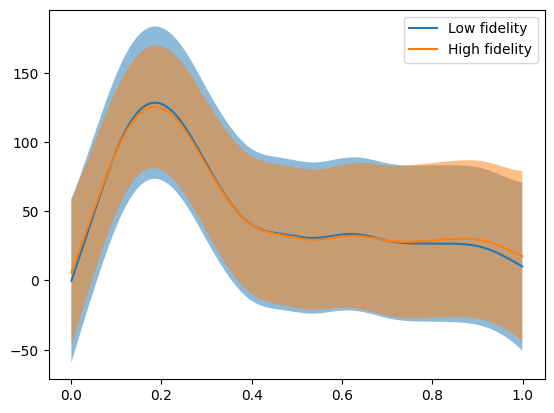

In [221]:
def get_X_plot(n: int, slice_values):
    X_plot = LatinDesign(space).get_samples(n)
    for param, value in slice_values.items():
        dim = space.find_parameter_index_in_model(param)[0]
        X_plot[:, dim] = value

    [x_var] = [param.name for param in space.parameters if param.name not in slice_values]
    x_dim = space.find_parameter_index_in_model(x_var)[0]
    x_1d_idx = np.argsort(X_plot[:, x_dim])  # Plot the first dimension only
    X_plot = X_plot[x_1d_idx]
    return X_plot


slice_values = {
    "INIT_PRED": 100,
    "INIT_PREY": 100,
    "PRED_SPAWN_RATE": 0,
    "PREY_SPAWN_RATE": 0,
    # "PREY_DEATH_FROM_PRED": 1,
}
n_plot = 1000

[x_var] = [param.name for param in space.parameters if param.name not in slice_values and param.name != "source"]
x_dim = space.find_parameter_index_in_model(x_var)[0]

X_plot_low = get_X_plot(n_plot, {**slice_values, "source": 0})
Y_mean_low, Y_var_low = mf_model.predict(X_plot_low, Y_metadata={"output_index": np.zeros(n_plot, dtype=int)})
X_plot_high = get_X_plot(n_plot, {**slice_values, "source": 1})
Y_mean_high, Y_var_high = mf_model.predict(X_plot_high, Y_metadata={"output_index": np.ones(n_plot, dtype=int)})

fig, ax = plt.subplots(1, 1)
ax.plot(X_plot_low[:, x_dim], Y_mean_low, label="Low fidelity")
ax.fill_between(
    X_plot_low[:, x_dim],
    (Y_mean_low - 1.96 * np.sqrt(Y_var_low))[:, 0],
    (Y_mean_low + 1.96 * np.sqrt(Y_var_low))[:, 0],
    alpha=0.5,
)
ax.plot(X_plot_high[:, x_dim], Y_mean_high, label="High fidelity")
ax.fill_between(
    X_plot_high[:, x_dim],
    (Y_mean_high - 1.96 * np.sqrt(Y_var_high))[:, 0],
    (Y_mean_high + 1.96 * np.sqrt(Y_var_high))[:, 0],
    alpha=0.5,
)
ax.legend()

Running high fidelity with HyperParams(REPRODUCTION_TYPE='FOOD', STEPS=1000, STARTING_PREY=100, STARTING_PREDATOR=100, STARTING_BERRY=0, MAX_BERRY=500, BERRY_VALUE=50, PREY_VALUE=50, PREY_STARTING_ENERGY=50, PREDATOR_STARTING_ENERGY=50, PREY_STARVATION=2, PREDATOR_STARVATION=2, PREY_STEP_ENERGY=0, PREDATOR_STEP_ENERGY=0, EATING_RADIUS=28.209479177387816, PREDATOR_EATING_PROBABILITY=0.025, PREY_REPRODUCTION_ENERGY_THRESHOLD=100, PREDATOR_REPRODUCTION_ENERGY_THRESHOLD=100, PREY_REPRODUCTION_PROBABILITY=1, PREDATOR_REPRODUCTION_PROBABILITY=1, SPEED=80, PREY_SPAWN_RATE=0.0, PREDATOR_SPAWN_RATE=0.0, BERRY_SPAWN_RATE=10, SIMULATION_TIMESTEP=0.5)
Running high fidelity with HyperParams(REPRODUCTION_TYPE='FOOD', STEPS=1000, STARTING_PREY=100, STARTING_PREDATOR=100, STARTING_BERRY=0, MAX_BERRY=500, BERRY_VALUE=50, PREY_VALUE=50, PREY_STARTING_ENERGY=50, PREDATOR_STARTING_ENERGY=50, PREY_STARVATION=2, PREDATOR_STARVATION=2, PREY_STEP_ENERGY=0, PREDATOR_STEP_ENERGY=0, EATING_RADIUS=28.209479177387

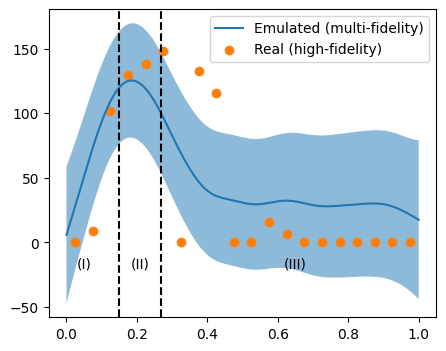

In [244]:
X_real = get_X_plot(20, {**slice_values, "source": 1})
Y_high = f_high(X_real[:, :-1])
# Y_low = f_low(X_real[:, :-1])

fig, ax = plt.subplots(figsize=(5, 4))

# ax.plot(X_plot_low[:, x_dim], Y_mean_low, label="Low fidelity")
# ax.fill_between(
#     X_plot_low[:, x_dim],
#     (Y_mean_low - 1.96 * np.sqrt(Y_var_low))[:, 0],
#     (Y_mean_low + 1.96 * np.sqrt(Y_var_low))[:, 0],
#     alpha=0.5,
# )
ax.plot(X_plot_high[:, x_dim], Y_mean_high, label="Emulated (multi-fidelity)")
ax.fill_between(
    X_plot_high[:, x_dim],
    (Y_mean_high - 1.96 * np.sqrt(Y_var_high))[:, 0],
    (Y_mean_high + 1.96 * np.sqrt(Y_var_high))[:, 0],
    alpha=0.5,
)

# ax.scatter(X_real[:, x_dim], Y_low[:, 0], label="Real (low)")
ax.scatter(X_real[:, x_dim], Y_high[:, 0], label="Real (high-fidelity)")
ax.axvline(0.15, color="k", linestyle="--")
ax.axvline(0.27, color="k", linestyle="--")
ax.text(0.05, -20, "(I)", horizontalalignment="center")
ax.text(0.21, -20, "(II)", horizontalalignment="center")
ax.text(0.65, -20, "(III)", horizontalalignment="center")
ax.set(
    xlabel="PREY_DEATH_FROM_PRED",
    ylabel="Average predator count",
)
ax.legend()

fig.savefig("logs/phase_change.png")

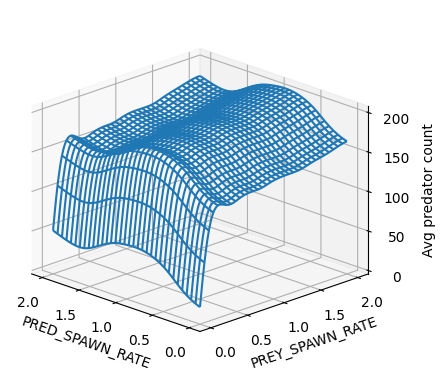

In [172]:
def get_X_plot(n: int, slice_values):
    X_plot = LatinDesign(space).get_samples(n)
    for param, value in slice_values.items():
        dim = space.find_parameter_index_in_model(param)[0]
        X_plot[:, dim] = value
    return X_plot


slice_values = {
    "INIT_PRED": 100,
    "INIT_PREY": 100,
    # "PRED_SPAWN_RATE": 0.05,
    # "PREY_SPAWN_RATE": 0.05,
    "PREY_DEATH_FROM_PRED": 1,
}
grid_size = 100

[x1_var, x2_var] = [
    param.name for param in space.parameters if param.name not in slice_values and param.name != "source"
]
X1_min, X1_max = space.get_parameter_by_name(x1_var).bounds[0]
X2_min, X2_max = space.get_parameter_by_name(x2_var).bounds[0]
X1_plot = np.linspace(X1_min, X1_max, grid_size)
X2_plot = np.linspace(X2_min, X2_max, grid_size)
X1_plot, X2_plot = np.meshgrid(X1_plot, X2_plot)

X_plot = np.empty((grid_size**2, space.dimensionality))
X_plot[:, space.find_parameter_index_in_model(x1_var)[0]] = X1_plot.flatten()
X_plot[:, space.find_parameter_index_in_model(x2_var)[0]] = X2_plot.flatten()
for param, value in slice_values.items():
    dim = space.find_parameter_index_in_model(param)[0]
    X_plot[:, dim] = value

X_plot[:, space.find_parameter_index_in_model("source")[0]] = 0
Y_mean_low, Y_var_low = mf_model.predict(X_plot, Y_metadata={"output_index": np.zeros(grid_size**2, dtype=int)})
X_plot[:, space.find_parameter_index_in_model("source")[0]] = 1
Y_mean_high, Y_var_high = mf_model.predict(X_plot, Y_metadata={"output_index": np.ones(grid_size**2, dtype=int)})

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d", "proj_type": "ortho"}, figsize=(5, 4))
ax.plot_wireframe(X1_plot, X2_plot, Y_mean_high.reshape(grid_size, grid_size), rcount=40, ccount=40)

ax.set(
    xlabel=x1_var,
    ylabel=x2_var,
    zlabel="Avg predator count",
    zlim=(0, None),
)
ax.invert_xaxis()
ax.view_init(elev=20, azim=-45)
fig.tight_layout()
fig.savefig(f"logs/{x1_var}_{x2_var}_3d.png", dpi=300)

In [198]:
from emukit.sensitivity.monte_carlo import ModelFreeMonteCarloSensitivity
import pandas as pd


def gp_predict_wrapper(X):
    return mf_model.predict(X, Y_metadata={"output_index": np.ones(X.shape[0], dtype=int)})[0]


sensitivity = ModelFreeMonteCarloSensitivity(gp_predict_wrapper, space)
main_effects, total_effects, _ = sensitivity.compute_effects()

df = pd.DataFrame(
    {
        "Main Effects": [array.item() for array in main_effects.values()],
        "Total Effects": [array.item() for array in total_effects.values()],
    },
    index=[param.name for param in space.parameters],
)
df.drop("source", inplace=True)
df

,Main Effects,Total Effects
INIT_PRED,0.009609,-0.001439
INIT_PREY,0.014201,-0.002251
PRED_SPAWN_RATE,0.095962,0.137770
PREY_SPAWN_RATE,0.157282,0.179551
PREY_DEATH_FROM_PRED,0.655232,0.714152


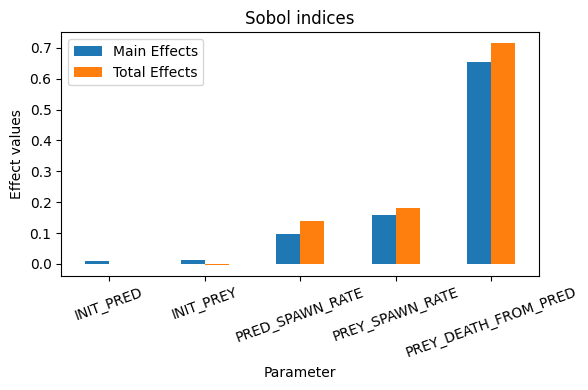

In [205]:
fig, ax = plt.subplots(figsize=(6, 4))
df.plot(kind="bar", rot=20, ax=ax)
ax.set(
    xlabel="Parameter",
    ylabel="Effect values",
    title="Sobol indices",
)
fig.tight_layout()
fig.savefig("logs/sobol_indices.png", dpi=300)

In [207]:
import json

with open("model/mf_params.json", "w") as f:
    json.dump(mf_model.to_dict(), f, indent=2)

Running high fidelity with HyperParams(REPRODUCTION_TYPE='FOOD', STEPS=1000, STARTING_PREY=100, STARTING_PREDATOR=100, STARTING_BERRY=0, MAX_BERRY=500, BERRY_VALUE=50, PREY_VALUE=50, PREY_STARTING_ENERGY=50, PREDATOR_STARTING_ENERGY=50, PREY_STARVATION=2, PREDATOR_STARVATION=2, PREY_STEP_ENERGY=0, PREDATOR_STEP_ENERGY=0, EATING_RADIUS=28.209479177387816, PREDATOR_EATING_PROBABILITY=1.0, PREY_REPRODUCTION_ENERGY_THRESHOLD=100, PREDATOR_REPRODUCTION_ENERGY_THRESHOLD=100, PREY_REPRODUCTION_PROBABILITY=1, PREDATOR_REPRODUCTION_PROBABILITY=1, SPEED=80, PREY_SPAWN_RATE=1.3000000000000003, PREDATOR_SPAWN_RATE=1.1, BERRY_SPAWN_RATE=10, SIMULATION_TIMESTEP=0.5)
Running high fidelity with HyperParams(REPRODUCTION_TYPE='FOOD', STEPS=1000, STARTING_PREY=100, STARTING_PREDATOR=100, STARTING_BERRY=0, MAX_BERRY=500, BERRY_VALUE=50, PREY_VALUE=50, PREY_STARTING_ENERGY=50, PREDATOR_STARTING_ENERGY=50, PREY_STARVATION=2, PREDATOR_STARVATION=2, PREY_STEP_ENERGY=0, PREDATOR_STEP_ENERGY=0, EATING_RADIUS=28

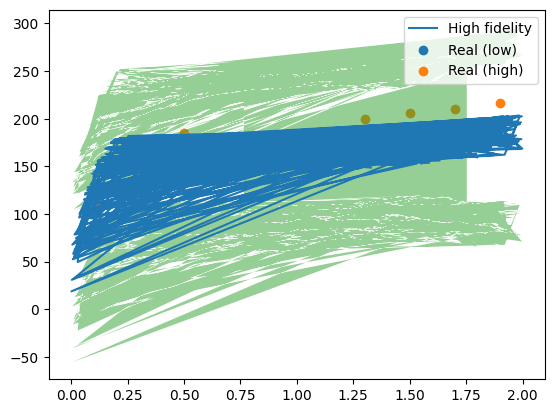

In [209]:
slice_values = {
    "INIT_PRED": 100,
    "INIT_PREY": 100,
    # "PRED_SPAWN_RATE": 0.05,
    "PREY_SPAWN_RATE": 0.05,
    "PREY_DEATH_FROM_PRED": 1,
}

# X_real = get_X_plot(10, {**slice_values, "source": 1})
# Y_high = f_high(X_real[:, :-1])
# Y_low = f_low(X_real[:, :-1])

[x_var] = [param.name for param in space.parameters if param.name not in slice_values and param.name != "source"]
X_plot = get_X_plot(n_plot, {**slice_values, "source": 1})
Y_mean, Y_var = mf_model.predict(X_plot, Y_metadata={"output_index": np.zeros(n_plot, dtype=int)})

fig, ax = plt.subplots()
# ax.scatter(X_real[:, x_dim], Y_low[:, 0], label="Real (low)")
# ax.scatter(X_real[:, x_dim], Y_high[:, 0], label="Real (high)")

ax.plot(X_plot[:, x_dim], Y_mean, label="High fidelity")
ax.fill_between(
    X_plot[:, x_dim],
    (Y_mean - 1.96 * np.sqrt(Y_var))[:, 0],
    (Y_mean + 1.96 * np.sqrt(Y_var))[:, 0],
    alpha=0.5,
)
ax.legend()